<a href="https://colab.research.google.com/github/ckwei379/titanic-analysis/blob/main/%E5%B0%88%E9%A1%8C%E5%AF%A6%E4%BD%9C_01%EF%BC%9A%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E5%AD%98%E6%B4%BB%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

專題實作 #01：鐵達尼號存活預測

環境準備

In [82]:
import pandas as pd
import numpy as np

In [83]:
# 載入 Titanic 資料集的 `train.csv` 資料集
df = pd.read_csv('https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv')

# 觀察資料
print(df.info())
print()

# 找出具有缺失值的欄位
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print("Missing Columns：")
print(missing_columns)
print()

# 資料清理
df["Sex"] = df["Sex"].map({"female":0, "male":1})
df["Age"] = df["Age"].fillna(df["Age"].mean())
df["Cabin"] = df["Cabin"].fillna(0)
df = pd.get_dummies(df, columns=["Embarked"], dtype=int)
df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)
print(df.head())
print()

# 確認資料清理後是否尚有缺失值
# "Age"欄位後續進行資料清理
has_missing = df.isna().values.any()
print("DataFrame has missing values：", has_missing)
print()

# 將清理後的資料複製存入訓練集
df_train = df.copy()

# 確認訓練集的資料
print(df_train.head())
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Missing Columns：
Age         177
Cabin       687
Embarked      2
dtype: int64

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked_C  Embarked_Q  \
0         0       3    1  22.0      1      0   7.2500           0           0 

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


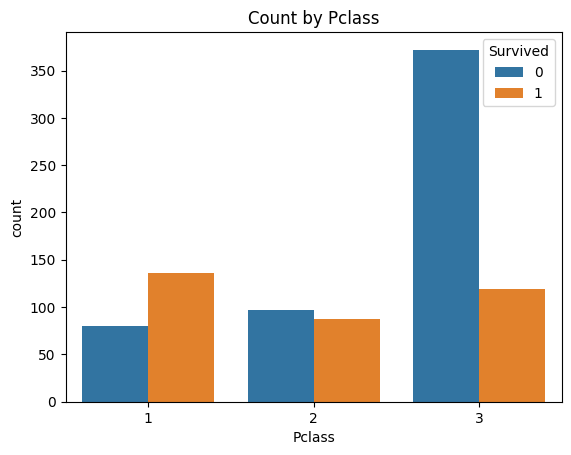

,Sex,Survived
0,0,0.742
1,1,0.189


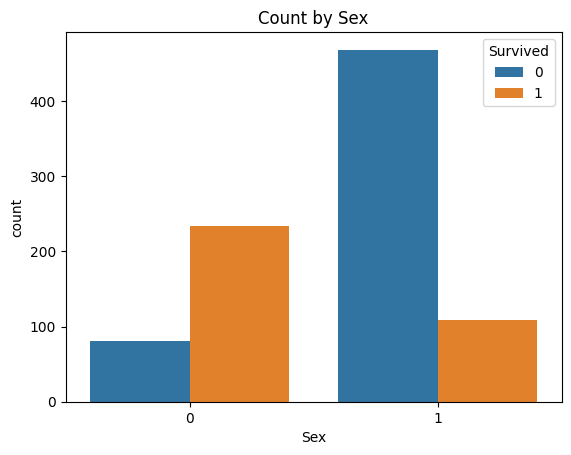

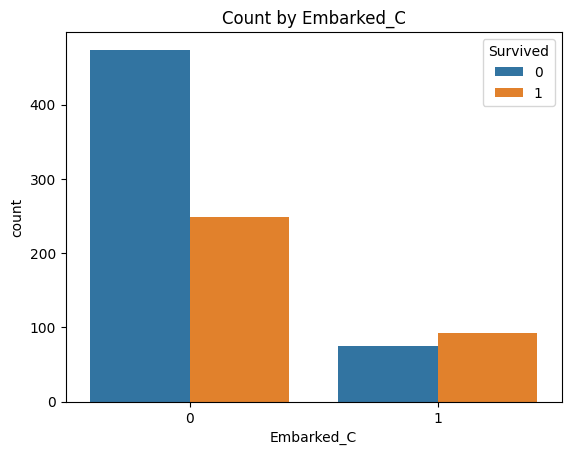

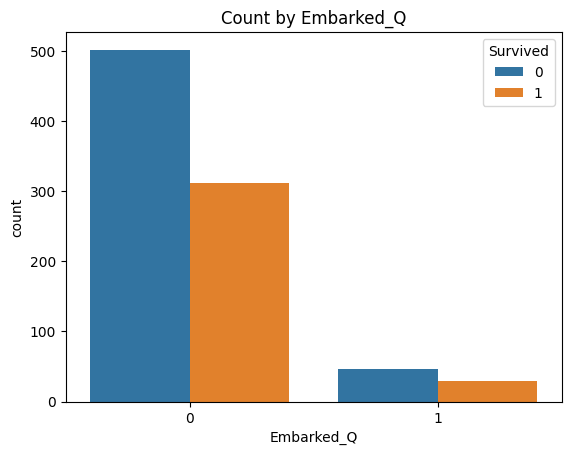

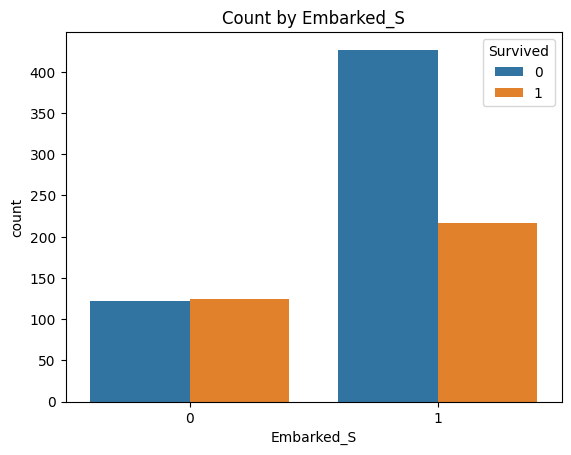

Correlation Matrix：
               Age      Fare  Survived
Age       1.000000  0.091566 -0.069809
Fare      0.091566  1.000000  0.257307
Survived -0.069809  0.257307  1.000000


In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

display(df[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean().round(3))
sns.countplot(x="Pclass", hue="Survived", data=df)
plt.title("Count by Pclass")
plt.show()

display(df[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean().round(3))
sns.countplot(x="Sex", hue="Survived", data=df)
plt.title("Count by Sex")
plt.show()

sns.countplot(x="Embarked_C", hue="Survived", data=df)
plt.title("Count by Embarked_C")
plt.show()

sns.countplot(x="Embarked_Q", hue="Survived", data=df)
plt.title("Count by Embarked_Q")
plt.show()

sns.countplot(x="Embarked_S", hue="Survived", data=df)
plt.title("Count by Embarked_S")
plt.show()

correlation = df[["Age", "Fare", "Survived"]].corr()
print("Correlation Matrix：")
print(correlation)

In [85]:
columns_X = list(set(df_train.columns) - {'Survived'})
columns_y = ['Survived']


train_X = df_train[columns_X]
train_y = df_train[columns_y]


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


log = LogisticRegression(random_state=0, max_iter=3000)
scores = cross_val_score(log, train_X, train_y.values.ravel(),cv=5,scoring='accuracy')
print(scores)

[0.78212291 0.78089888 0.78651685 0.76966292 0.8258427 ]


<ipython-input-86-2454086dab0f>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Base_Model.fit(train_X[Base], train_y)


Base oob score：0.73176

Pclass            1   2    3
FareBin_Code_4              
0                 6   6  211
1                 0  86  138
2                51  70  101
3               159  22   41

Pclass            1   2    3
FareBin_Code_5              
0                 6   6  167
1                 0  24  160
2                 0  80   92
3                64  64   52
4               146  10   20

Pclass            1   2    3
FareBin_Code_6              
0                 6   6  144
1                 0   0  152
2                 0  86   53
3                 6  53   90
4                76  32   38
5               128   7   14



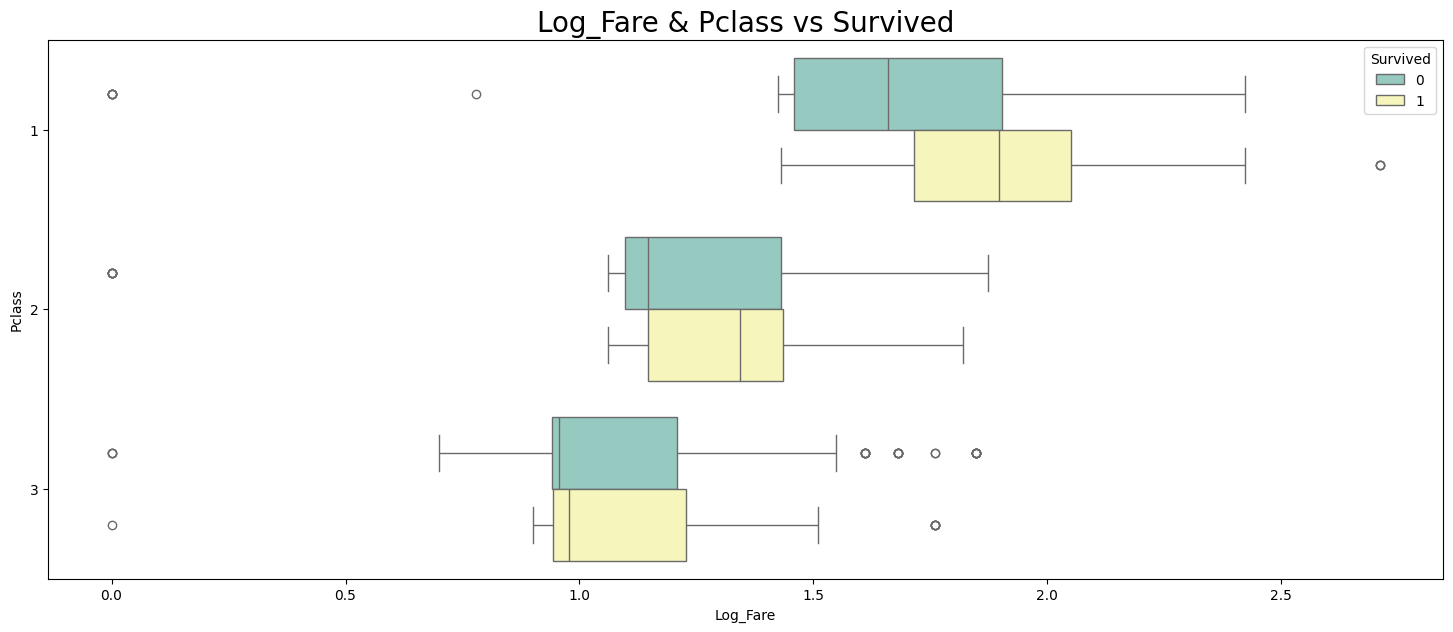

In [86]:
from sklearn.ensemble import RandomForestClassifier

# Show Baseline
Base = ["Sex", "Pclass"]
Base_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
Base_Model.fit(train_X[Base], train_y)
print("Base oob score：%.5f" %(Base_Model.oob_score_))
print()

# 資料視覺化：票價和艙等vs生存機率
# There is some bugs in log-scale of boxplot
# Alternatively, we transform x into log10(x) for visualization
fig, ax = plt.subplots(figsize=(18,7))
df["Log_Fare"] = (df["Fare"]+1).map(lambda x: np.log10(x) if x > 0 else 0)
sns.boxplot(y="Pclass", x="Log_Fare", hue="Survived", data=df, orient="h", ax=ax, palette="Set3")
ax.set_title("Log_Fare & Pclass vs Survived", fontsize=20)
pd.pivot_table(df, values=["Fare"], index=["Pclass"], columns=["Survived"], aggfunc="median").round(3)

# 存活乘客平均而言付出較高的票價
# 特徵工程：將票價分別切分成4，5，6個區間，並命名為新的特徵，找出最合適的區間個數
# 切分的區間太少，不易看出差異性使特徵失真；切分的區間太多，可能產生overfitting
# Making Bins
df["FareBin_4"] = pd.qcut(df["Fare"], 4)
df["FareBin_5"] = pd.qcut(df["Fare"], 5)
df["FareBin_6"] = pd.qcut(df["Fare"], 6)

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
df["FareBin_Code_4"] = label.fit_transform(df["FareBin_4"])
df["FareBin_Code_5"] = label.fit_transform(df["FareBin_5"])
df["FareBin_Code_6"] = label.fit_transform(df["FareBin_6"])

# Cross Tab
df_4 = pd.crosstab(df["FareBin_Code_4"], df["Pclass"])
print(df_4)
print()
df_5 = pd.crosstab(df["FareBin_Code_5"], df["Pclass"])
print(df_5)
print()
df_6 = pd.crosstab(df["FareBin_Code_6"], df["Pclass"])
print(df_6)
print()

In [87]:
df_train = df[:len(df_train)]
df_test = df[len(df_train):]

train_X = df_train.drop(labels=["Survived"], axis=1)
train_y = df_train["Survived"]

train_X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Log_Fare', 'FareBin_4', 'FareBin_5',
       'FareBin_6', 'FareBin_Code_4', 'FareBin_Code_5', 'FareBin_Code_6'],
      dtype='object')

In [88]:
# Feature Selection
# 前向選擇法：可以考慮到特徵之間的交互作用，缺點是需要較大的運算資源
from sklearn.feature_selection import RFECV
compare = ["Sex", "Pclass", "FareBin_Code_4", "FareBin_Code_5", "FareBin_Code_6"]

# Initialize RFECV
selector = RFECV(RandomForestClassifier(n_estimators=250, min_samples_split=20), cv=10, n_jobs=-1)
selector.fit(train_X[compare], train_y)

# Accessing the cross-validation results
print("Optimal number of features : %d" % selector.n_features_)
print("Selected features : %s" % selector.support_)

# Accessing the cross-validation scores
print("CV scores: ", selector.cv_results_['mean_test_score']*100)

Optimal number of features : 5
Selected features : [ True  True  True  True  True]
CV scores:  [78.67290886 77.55430712 79.24219725 79.68913858 80.25468165]


In [89]:
# 切分成6份可得到較高的CV分數，但還沒有考慮到模型的random_state以及Cross-Validation切分方式
# 確認切成6份是否為最好的選項
from sklearn.model_selection import StratifiedKFold
score_b4, score_b5, score_b6 = [], [], []
seeds = 10
for i in range(seeds):
  # Stratified K-Fold Cross-Validation
  diff_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
  # Feature Selection with RFECV
  selector = RFECV(RandomForestClassifier(random_state=i, n_estimators=250, min_samples_split=20), cv=diff_cv, n_jobs=-1)
  selector.fit(train_X[compare], train_y)
  # Storing Results
  score_b4.append(selector.cv_results_['mean_test_score'][2])
  score_b5.append(selector.cv_results_['mean_test_score'][3])
  score_b6.append(selector.cv_results_['mean_test_score'][4])

b4 oob score：0.79686  LB_Public：0.7790
b5 oob score：0.81033  LB_Public：0.79425
b6 oob score：0.80135  LB_Public：0.77033


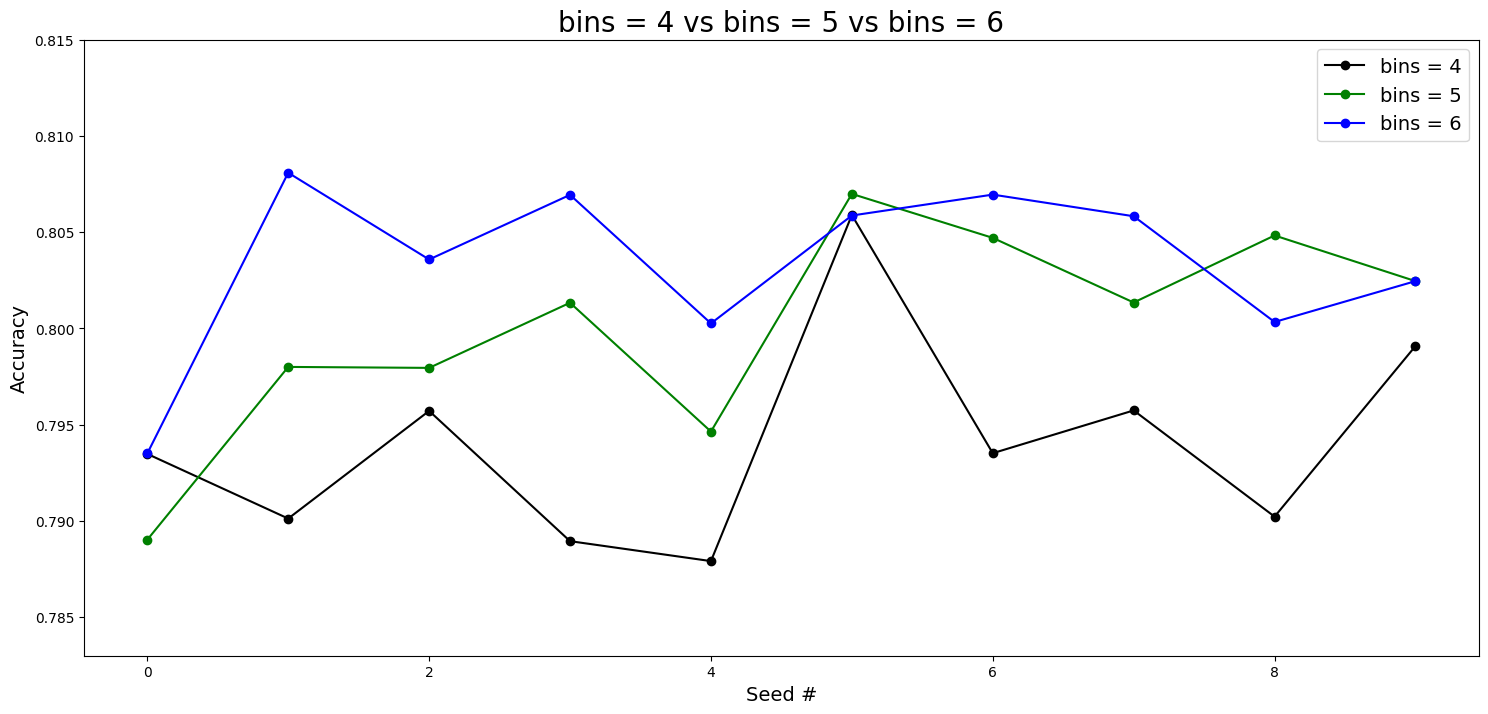

In [90]:
# Converting to numpy arrays
score_list = [score_b4, score_b5, score_b6]
for item in score_list:
  item = np.array(item*100)

# Plotting
# Figure and Axis Setup
fig = plt.figure(figsize=(18,8))
ax = plt.gca()
# Plotting Lines
ax.plot(range(seeds), score_b4, "-ok", label="bins = 4")
ax.plot(range(seeds), score_b5, "-og", label="bins = 5")
ax.plot(range(seeds), score_b6, "-ob", label="bins = 6")
# Axis Labels and Title
ax.set_xlabel("Seed #", fontsize="14")
ax.set_ylim(0.783, 0.815)
ax.set_ylabel("Accuracy", fontsize="14")
ax.set_title("bins = 4 vs bins = 5 vs bins = 6", fontsize="20")
plt.legend(fontsize=14, loc="upper right")

# Model Fitting and Out-of-Bag (OOB) Scores
# Define Feature Sets
b4, b5, b6 = ["Sex", "Pclass", "FareBin_Code_4"], ["Sex", "Pclass", "FareBin_Code_5"],\
 ["Sex", "Pclass", "FareBin_Code_6"]
# Instantiate and Train Models
b4_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
b4_Model.fit(train_X[b4], train_y)
b5_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
b5_Model.fit(train_X[b5], train_y)
b6_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
b6_Model.fit(train_X[b6], train_y)
# Instantiate and Train Models
print("b4 oob score：%.5f" %(b4_Model.oob_score_)," LB_Public：0.7790")
print("b5 oob score：%.5f" %(b5_Model.oob_score_)," LB_Public：0.79425")
print("b6 oob score：%.5f" %(b6_Model.oob_score_)," LB_Public：0.77033")
# 由圖可以看出切分成4份的準確率較低，6份比5份稍微好一點，在CV的結果也是這樣
# 但在oob score排行榜上的分數反而是切分成5份最高分，而不是6份
# 這個情況在Titanic這個資料集上很常見，可能是某種過度的特徵工程所帶來的overfitting

觀察特徵 "Connected_Survival", "Age", "Family_size"

In [91]:
df1 = pd.read_csv('https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv')
# 觀察票根的特徵
df1["Ticket"].describe()
# 乘客持有相同的船票意味著他們可能是家人或是朋友，而在訓練集上這些互相有連結的人常常是一起活下來或是一起喪命
# 在891個票根資訊中，獨立的有681項，這表示一定有乘客是持有相同的票根，這意味著他們可能一起分享某一區的座位
df1_train = df1.copy()

In [92]:
# Family_size
# 建立家庭人數特徵(將兄弟姊妹數SibSp+父母小孩數Parch+1)方便接下來的觀察
df1["Family_size"] = df1["SibSp"] + df1["Parch"] + 1

# 建立持有相同票根的DataFrame，並顯示姓名、票價、艙位、家庭人數
deplicate_ticket = []
# Iterate through Unique Tickets
for tk in df1.Ticket.unique():
  # Creates a subset "tem" of fares where the ticket number matches tk
  tem = df1.loc[df1.Ticket == tk, "Fare"]
  # print(tem.count())
  if tem.count() > 1:
    # print(df1.loc[df.Ticket == tk, ["Name", "Ticket", "Fare"]])
    deplicate_ticket.append(df1.loc[df1.Ticket == tk, ["Name", "Ticket", "Fare", "Cabin", "Family_size", "Survived"]])
# Concatenates all DataFrames stored in "deplicate_ticket" into a single DataFrame
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(14)

,Name,Ticket,Fare,Cabin,Family_size,Survived
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",347742,11.1333,NaN,3,1
172,"Johnson, Miss. Eleanor Ileen",347742,11.1333,NaN,3,1
869,"Johnson, Master. Harold Theodor",347742,11.1333,NaN,3,1
9,"Nasser, Mrs. Nicholas (Adele Achem)",237736,30.0708,NaN,2,1


In [93]:
# 透過Family_size來分類，Family_size = 1但又在群組內的，即非親屬關係，歸類為朋友；Family_size > 1則為家人
df1_fri = deplicate_ticket.loc[(deplicate_ticket.Family_size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
df1_fami = deplicate_ticket.loc[(deplicate_ticket.Family_size > 1) & (deplicate_ticket.Survived.notnull())].head(7)
display(df1_fri, df1_fami)
print("people keep the same ticket：%.0f" %len(deplicate_ticket))
print("friends：%.0f" %len(deplicate_ticket[deplicate_ticket.Family_size == 1]))
print("families：%.0f" %len(deplicate_ticket[deplicate_ticket.Family_size > 1]))

,Name,Ticket,Fare,Cabin,Family_size,Survived
20,"Fynney, Mr. Joseph J",239865,26.0000,NaN,1,0
791,"Gaskell, Mr. Alfred",239865,26.0000,NaN,1,0
195,"Lurette, Miss. Elise",PC 17569,146.5208,B80,1,1
681,"Hassab, Mr. Hammad",PC 17572,76.7292,D49,1,1
61,"Icard, Miss. Amelie",113572,80.0000,B28,1,1
829,"Stone, Mrs. George Nelson (Martha Evelyn)",113572,80.0000,B28,1,1
72,"Hood, Mr. Ambrose Jr",S.O.C. 14879,73.5000,NaN,1,0


,Name,Ticket,Fare,Cabin,Family_size,Survived
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",347742,11.1333,NaN,3,1


people keep the same ticket：344
friends：75
families：269


Sex,female,male,All
Has_Age,,,
0,53,124,177
1,261,453,714
All,314,577,891


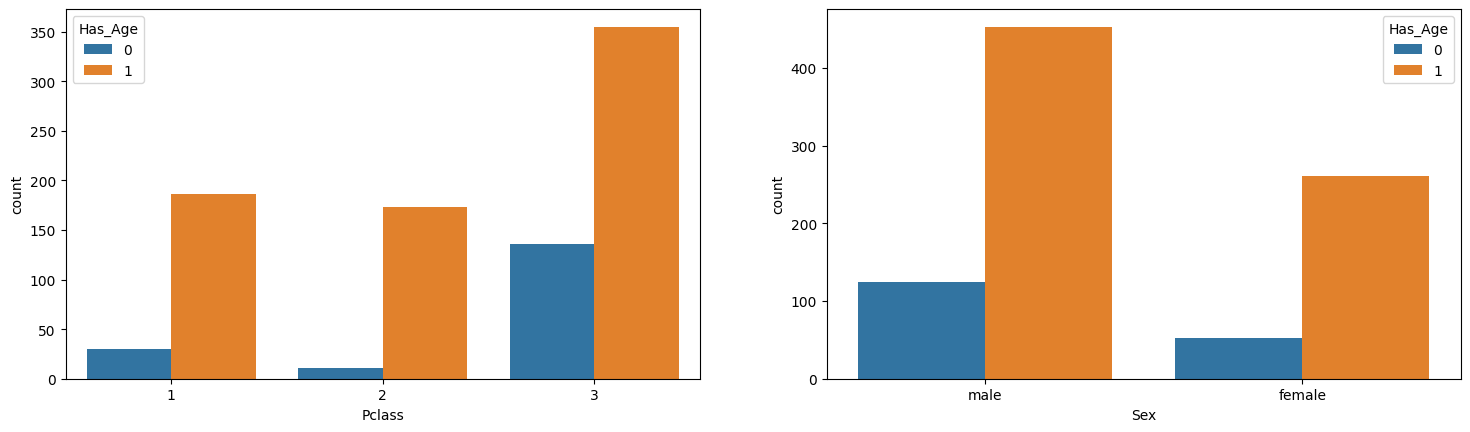

In [94]:
# 如果缺失年齡都特別屬於某個性別，或是特別屬於某個艙等，就很有可能影響預測
df1["Has_Age"] = df1["Age"].isnull().map(lambda x: 0 if x == True else 1)
fig, [ax1, ax2] = plt.subplots(1,2)
fig.set_figwidth(18)
ax1 = sns.countplot(x=df1["Pclass"], hue=df1["Has_Age"], ax=ax1)
ax2 = sns.countplot(x=df1["Sex"], hue=df1["Has_Age"], ax=ax2)
pd.crosstab(df1["Has_Age"], df1["Sex"], margins=True).round(3)
# 從左圖可以明顯看出年齡缺失值蠻大部分在3等艙，如果年齡真的是重要特徵，則我們對3等艙的觀察就會失真，保守作法是觀察1,2艙等中年齡對存活與否的影響
# 右圖則顯示缺失值對性別的分布，搭配著表格看的話，男性缺失年齡稍微多一點，如果年齡對生存與否有影響的話，可能可以搭配男性藉此被區分出更多的生還者(例如男性小孩生還率有可能高於男性成人)

<ipython-input-95-e63ba4371d4c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df1.loc[Mask_Has_Age_P12_Survived, "Age"], kde=False, bins=10, norm_hist=True, label="Survived")
<ipython-input-95-e63ba4371d4c>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df1.loc[Mask_Has_Age_P12_De

Text(0.5, 1.0, 'Age vs Survived in Pclass = 1 and 2')

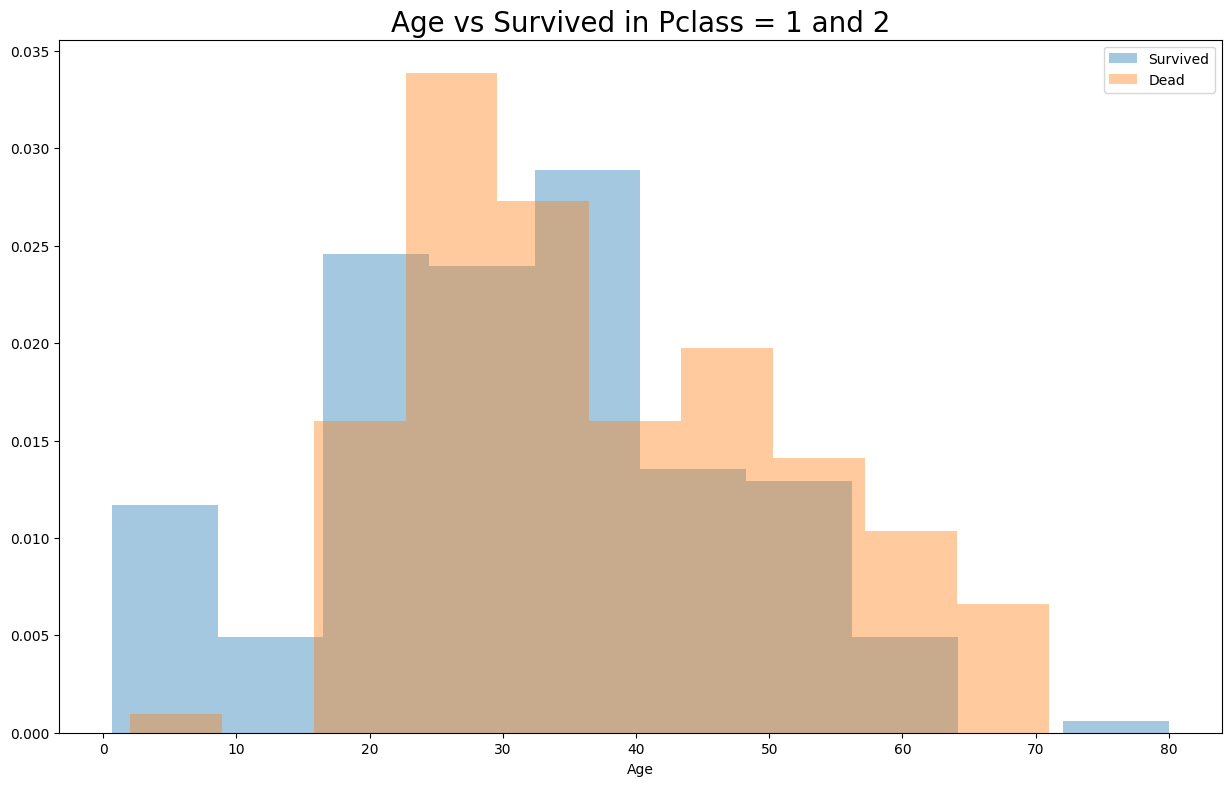

In [95]:
# Masks
# 1,2艙之中，年齡對存活與否的影響
Mask_Has_Age_P12_Survived = ((df1.Has_Age == 1) & (df1.Pclass != 3) & (df1.Survived == 1))
Mask_Has_Age_P12_Dead = ((df1.Has_Age == 1) & (df1.Pclass != 3) & (df1.Survived == 0))

# Plot
fig, ax = plt.subplots(figsize = (15,9))
ax = sns.distplot(df1.loc[Mask_Has_Age_P12_Survived, "Age"], kde=False, bins=10, norm_hist=True, label="Survived")
ax = sns.distplot(df1.loc[Mask_Has_Age_P12_Dead, "Age"], kde=False, bins=10, norm_hist=True, label="Dead")
ax.legend()
ax.set_title("Age vs Survived in Pclass = 1 and 2", fontsize=20)
# 圖中可以看到，左邊藍色部分多出一塊，也就是這部分生存率較高，約<16歲，表示青少年以下(包含小孩)有較高的生存率
# 若>16歲，基本上年齡不算是一個顯著的特徵來判定是否生還，而70~80歲的這個區間，由於樣本數太少，因此不列入採計
# 綜合上述討論，找出<16歲的缺失值是重要的，這會影響預測，而>16歲的部分則不採用，否則只是擬合了噪聲，因此年齡這個特徵可以抽取出<16歲及>16歲做為一個2元特徵

In [96]:
# Extracted title using name
# 填入缺失值的方式選擇使用姓名當中的稱謂中位數來填補，比起填中位數要準確

# Extract Titles from Names
df1["Title"] = df1.Name.str.extract("([A-Za-z]+)\.", expand=False)
# Replace Certain Titles with 'Rare'
df1["Title"] = df1["Title"].replace(["Capt", "Col", "Countess", "Don", "Dr", "Dona", "Jonkheer", "Major", "Rev", "Sir"], "Rare")
# Group Certain Titles as 'Miss'
df1["Title"] = df1["Title"].replace(["Mile", "Ms", "Mme"], "Miss")
# Group 'Lady' Title as 'Mrs'
df1["Title"] = df1["Title"].replace(["Lady"], "Mrs")
# Map Titles to Numerical Values
df1["Title"] = df1["Title"].map({"Mr": 0, "Rare": 1, "Master": 2, "Miss": 3, "Mrs": 4})
# Calculate Median Age for Each Title
Ti = df1.groupby("Title")["Age"].median()
Ti

Title
0.0    30.0
1.0    49.0
2.0     3.5
3.0    21.0
4.0    35.0
Name: Age, dtype: float64

In [97]:
# Compute Median Age for Each Title
Ti_pred = df1.groupby("Title")["Age"].median().values
# Initialize "Ti_Age" Column
df1["Ti_Age"] = df1["Age"]
# Fill Missing Ages Based on Title
for i in range(0, 5):
  # 0 1 2 3 4 5
  df1.loc[(df1.Age.isnull()) & (df1.Title == i), "Ti_Age"] = Ti_pred[i]
# Convert "Ti_Age" to Integer Type
df1["Ti_Age"] = df1["Ti_Age"].astype("int")
# 將填滿年齡的特徵創建為Ti_Age，分為<16歲及>16歲，命名為Ti_Minor
# Multiplying by 1 converts these boolean values to integers (1 for True, 0 for False)
df1["Ti_Minor"] = ((df1["Ti_Age"]) < 16.0) * 1

In [98]:
df1["Sex"] = df1["Sex"].map({"female":0, "male":1})
# Splits again because we just engineered new feature
df1_train = df1[:len(df1_train)]
df1_test = df1[len(df1_train):]
# Training set and labels
train_X1 = df1_train.drop(labels=["Survived", "PassengerId"], axis=1)
train_y1 = df1_train["Survived"]

In [99]:
# 加入模型、訓練、觀察oob score
minor = ["Sex", "Pclass", "Ti_Minor"]
minor_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
minor_Model.fit(train_X1[minor], train_y1)
print("minor oob score: %.5f" %(minor_Model.oob_score_))

minor oob score: 0.79349


In [106]:
# Cut into 3 class
# Create Binary Feature Based on Family Size
df1['L_Family'] = df1['Family_size'].apply(lambda x: 0 if x<= 4 else 1).astype(int)
# Categorize Family Size into Classes
df1.loc[ df1['Family_size'] == 1, 'FamilyClass'] = 0
df1.loc[ (df1['Family_size'] <= 4) & (df1['Family_size'] > 1), 'FamilyClass'] = 1
df1.loc[ df1['Family_size'] >= 5, 'FamilyClass'] = 2
df1['FamilyClass'] = df1['FamilyClass'].astype(int)
# Analyze Survival Rates by Family Class
df1[['FamilyClass','Survived']].groupby(['FamilyClass']).mean()

,Survived
FamilyClass,
0,0.303538
1,0.578767
2,0.161290


<Axes: title={'center': 'Sex'}, xlabel='Family_size'>

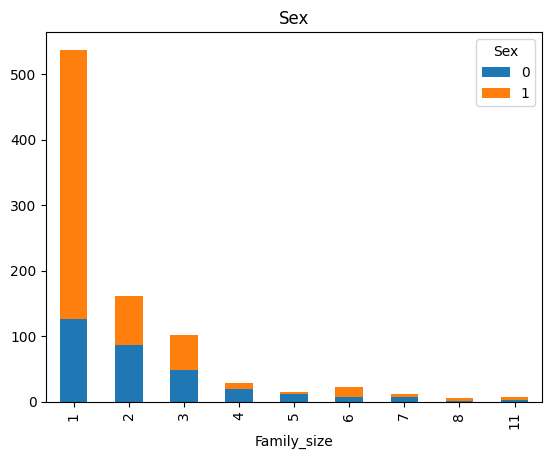

In [107]:
# 家庭人數對性別的分析
# Visualize
pd.crosstab(df1['Family_size'],df1['Sex']).plot(kind='bar',stacked=True,title="Sex")
# 圖中可以看到家庭人數=1之中有接近75%的男性，男性生存率本來就低，FamilyClass=0有可能僅是性別特徵的一個重複

<ipython-input-115-e18176dd06c7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df1[Minor_mask]['Family_size'],ax=ax1, palette="Set2")


<Axes: title={'center': 'Survived Minor counts'}, xlabel='Family_size'>

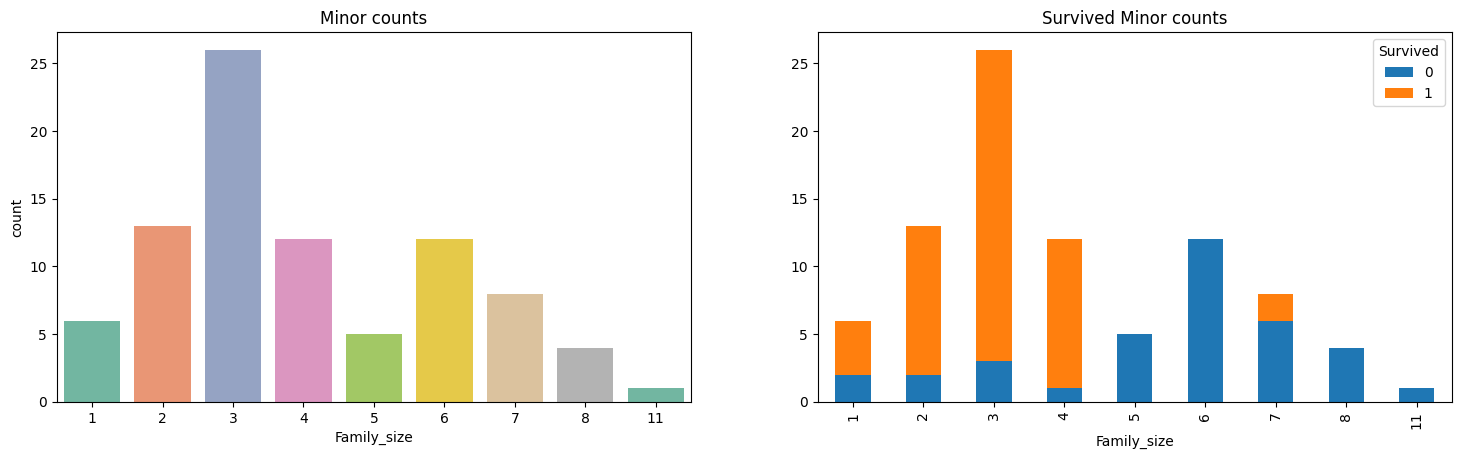

In [115]:
# 家庭人數對小孩數量的分析
Minor_mask = (df1.Ti_Minor == 1)
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
# Count Plot of Minors by Family Size
sns.countplot(x=df1[Minor_mask]['Family_size'],ax=ax1, palette="Set2")
ax1.set_title("Minor counts")
# Stacked Bar Plot of Survival Counts for Minors by Family Size
pd.crosstab(df1[Minor_mask]['Family_size'],df1[Minor_mask]['Survived']).plot(kind='bar',stacked=True,title="Survived Minor counts",ax=ax2)
# 在家庭人數=2,3,4中，除了小孩的個數較高之外，存活的比例也較高，這意味著家庭人數=2~4人的生存率較高很有可能僅是小孩存活的多，這已涵蓋在Minor的特徵中
# 而Family_size>5人，從分析中並沒有看出和其他特徵相關的影子